# Linear Modeling in Python

This notebook, which was created and presented by Skipper Sebold at the Scipy2012, introduces the use of pandas and the formula framework in statsmodels in the context of linear modeling.

**It is based heavily on Jonathan Taylor's [class notes that use R](http://www.stanford.edu/class/stats191/interactions.html)**

In [1]:
#filter warnings
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import pandas
import numpy as np

from statsmodels.formula.api import ols
from statsmodels.graphics.api import interaction_plot, abline_plot, qqplot
from statsmodels.stats.api import anova_lm

In [2]:
%matplotlib inline

## Example 1: IT salary data

In this example we will first establish a linear model, of salary as a function of experience, education, and management level.
We will test for any interactions between these factors. Significant interactions will be included in the model.
Finally, we will remove outliers, and plot the resulting fits.

### Get the data

In [3]:
url = 'http://stats191.stanford.edu/data/salary.table'
salary_table = pandas.read_table(url) # needs pandas 0.7.3
#salary_table.to_csv('salary.table', index=False)

### Inspect the data

In [4]:
print(salary_table.head(10))

       S  X  E  M
0  13876  1  1  1
1  11608  1  3  0
2  18701  1  3  1
3  11283  1  2  0
4  11767  1  3  0
5  20872  2  2  1
6  11772  2  2  0
7  10535  2  1  0
8  12195  2  3  0
9  12313  3  2  0


In [5]:
E = salary_table.E # Education
M = salary_table.M # Management
X = salary_table.X # Experience
S = salary_table.S # Salary

Let's explore the data

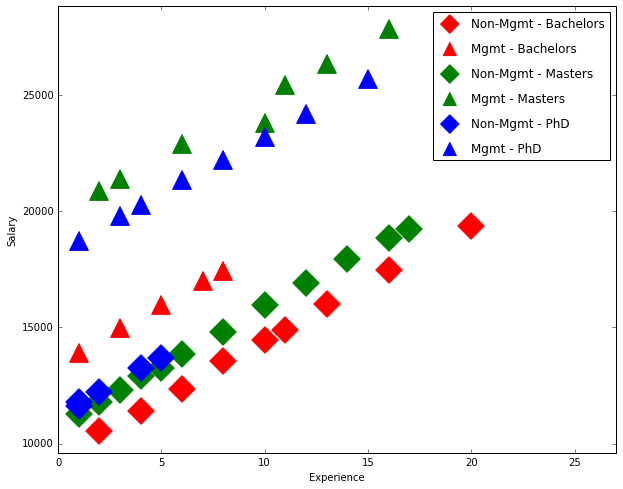

In [6]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, xlabel='Experience', ylabel='Salary',
            xlim=(0, 27), ylim=(9600, 28800))
symbols = ['D', '^']
man_label = ["Non-Mgmt", "Mgmt"]
educ_label = ["Bachelors", "Masters", "PhD"]
colors = ['r', 'g', 'blue']
factor_groups = salary_table.groupby(['E','M'])
for values, group in factor_groups:
    i,j = values
    label = "%s - %s" % (man_label[j], educ_label[i-1])
    ax.scatter(group['X'], group['S'], marker=symbols[j], color=colors[i-1],
               s=350, label=label)
ax.legend(scatterpoints=1, markerscale=.7, labelspacing=1);

### Define and Fit a Linear Model

Fit a linear model

$$S_i = \beta_0 + \beta_1X_i + \beta_2E_{i2} + \beta_3E_{i3} + \beta_4M_i + \epsilon_i$$

where

$$ E_{i2}=\cases{1,&if $E_i=2$;\cr 0,&otherwise. \cr}$$ 
$$ E_{i3}=\cases{1,&if $E_i=3$;\cr 0,&otherwise. \cr}$$ 


In the following, the model is defined using "patsy".

- An intercept is automatically included.
- C(variable) includes the variable automatically as categories.

In [7]:
formula = 'S ~ C(E) + C(M) + X'
lm = ols(formula, salary_table).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                      S   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     226.8
Date:                Mon, 25 Jan 2016   Prob (F-statistic):           2.23e-27
Time:                        17:10:45   Log-Likelihood:                -381.63
No. Observations:                  46   AIC:                             773.3
Df Residuals:                      41   BIC:                             782.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   8035.5976    386.689     20.781      0.0

*Dep. Variable*
    the variable to be fitted; here, the "Salary"

*Model*
    OLS = ordinary least squares

*Df Residuals*
    The number of observations, minus the number of parameters fitted.

*Df model*
    "Degree of Freedom" of the model, i.e. the dimensionnality of the subspace spanned by the model. This entails that the intercept is not counted.

*R-squared*
    Coefficient of Determination = (S0-Sm)/S0

*Adj. R-squared*
    The adjusted R2 coefficient, which takes into consideration the number of model paramters.

*F-statistic*, and corresponding *Prob*
    F-test on the regression model, if it is significantly different from the minimum model (i.e. a constant offset only)

*Log-Likelihood*
    Maximum log-likelihood value for the model.

*AIC*
    Aiken's Information Criterion, for the assessment of the model.

*BIC*
    Bayesian Information Criterion, for the assessment of the model.

The values in the lowest box describe properties of the residuals ("Skew", "Kurtosisi"), as well as tests on the residuals.

### Inspect the Design Matrix, and demonstrate the Model Predictions

Look at the design matrix created for us. Every results instance has a reference to the model.

In [8]:
lm.model.exog[:10]

array([[ 1.,  0.,  0.,  1.,  1.],
       [ 1.,  0.,  1.,  0.,  1.],
       [ 1.,  0.,  1.,  1.,  1.],
       [ 1.,  1.,  0.,  0.,  1.],
       [ 1.,  0.,  1.,  0.,  1.],
       [ 1.,  1.,  0.,  1.,  2.],
       [ 1.,  1.,  0.,  0.,  2.],
       [ 1.,  0.,  0.,  0.,  2.],
       [ 1.,  0.,  1.,  0.,  2.],
       [ 1.,  1.,  0.,  0.,  3.]])

Since we initially passed in a DataFrame, we have a transformed DataFrame available.

In [9]:
print(lm.model.data.orig_exog.head(10))

   Intercept  C(E)[T.2]  C(E)[T.3]  C(M)[T.1]  X
0          1          0          0          1  1
1          1          0          1          0  1
2          1          0          1          1  1
3          1          1          0          0  1
4          1          0          1          0  1
5          1          1          0          1  2
6          1          1          0          0  2
7          1          0          0          0  2
8          1          0          1          0  2
9          1          1          0          0  3


There is a reference to the original untouched data in

In [10]:
print(lm.model.data.frame.head(10))

       S  X  E  M
0  13876  1  1  1
1  11608  1  3  0
2  18701  1  3  1
3  11283  1  2  0
4  11767  1  3  0
5  20872  2  2  1
6  11772  2  2  0
7  10535  2  1  0
8  12195  2  3  0
9  12313  3  2  0


If you use the formula interface, statsmodels remembers this transformation. Say you want to know the predicted salary for someone with 12 years experience and a Master's degree who is in a management position

In [11]:
lm.predict({'X' : [12], 'M' : [1], 'E' : [2]})

array([ 24617.37207242])

### Check the Residuals

So far we've assumed that the effect of experience is the same for each level of education and professional role.
Perhaps this assumption isn't merited. We can formally test this using some interactions.

We can start by seeing if our model assumptions are met. Let's look at a residuals plot, with the groups separated.

In [12]:
resid = lm.resid

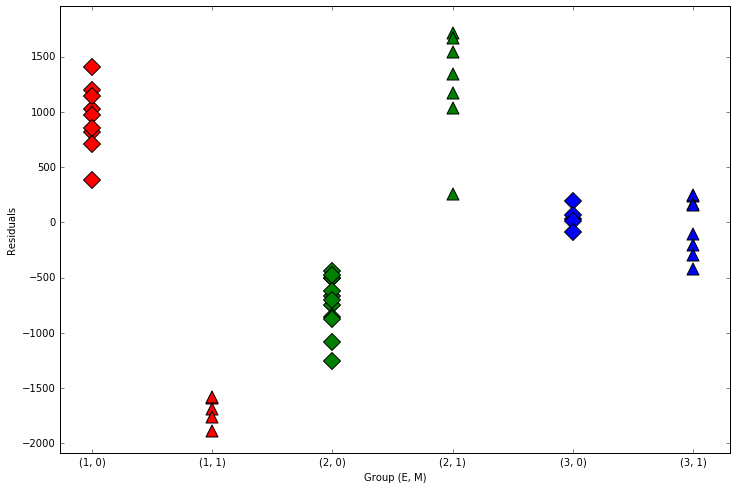

In [13]:
fig = plt.figure(figsize=(12,8))
xticks = []
ax = fig.add_subplot(111, xlabel='Group (E, M)', ylabel='Residuals')
for values, group in factor_groups:
    i,j = values
    xticks.append(str((i, j)))
    group_num = i*2 + j - 1 # for plotting purposes
    x = [group_num] * len(group)
    ax.scatter(x, resid[group.index], marker=symbols[j], color=colors[i-1],
            s=144, edgecolors='black')
ax.set_xticks([1,2,3,4,5,6])
ax.set_xticklabels(xticks)
ax.axis('tight');


Obviously, the linear model alone does not capture all model features, as the residuals are not normally distributed within each group. To improve the model, we check if interactions between the model parameters can explain the group differences.

### Add an Interaction

#### Interaction Salary*Experience

Add an interaction between salary and experience, allowing different intercepts for level of experience.

$$S_i = \beta_0+\beta_1X_i+\beta_2E_{i2}+\beta_3E_{i3}+\beta_4M_i+\beta_5E_{i2}X_i+\beta_6E_{i3}X_i+\epsilon_i$$

In [14]:
interX_lm = ols('S ~ C(E)*X + C(M)', salary_table).fit()
print(interX_lm.summary())

                            OLS Regression Results                            
Dep. Variable:                      S   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     158.6
Date:                Mon, 25 Jan 2016   Prob (F-statistic):           8.23e-26
Time:                        17:10:45   Log-Likelihood:                -379.47
No. Observations:                  46   AIC:                             772.9
Df Residuals:                      39   BIC:                             785.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept    7256.2800    549.494     13.205      

The "Factor" Experience has the "Treatments" (or elements) "1", "2", and "3". Since the "Treatment 1"([T.1]) is taken as the reference, it is not listed here explicitly. This is called "corner-point" approach.
Similarly, the "Factor" Management has the "Treatments" "0" and "1". With "0" taken as the reference, only the term C(M)[T.1] is listed in the model.
The interactions are described by the terms "C(E)[T.i]:X".

##### Test the Interaction Management*Experience

Test that $\beta_5 = \beta_6 = 0$. We can use anova_lm or we can use an F-test.

In [15]:
print(anova_lm(lm, interX_lm))

   df_resid              ssr  df_diff         ss_diff         F    Pr(>F)
0        41  43280719.492876        0             NaN       NaN       NaN
1        39  39410679.807560        2  3870039.685316  1.914856  0.160964


In [16]:
print(interX_lm.f_test('C(E)[T.2]:X = C(E)[T.3]:X = 0'))

<F test: F=array([[ 1.91485593]]), p=0.16096422424743334, df_denom=39, df_num=2>


In [17]:
print(interX_lm.f_test([[0,0,0,0,0,1,-1],[0,0,0,0,0,0,1]]))

<F test: F=array([[ 1.91485593]]), p=0.16096422424743334, df_denom=39, df_num=2>


Both tests show that the models are not significantly different. In other words, there is no interaction effect between Management and Experience in the data.

The contrasts are created here under the hood by patsy.

Recall that F-tests are of the form $R\beta = q$

In [18]:
LC = interX_lm.model.data.orig_exog.design_info.linear_constraint('C(E)[T.2]:X = C(E)[T.3]:X = 0')
print(LC.coefs)
print(LC.constants)

[[ 0.  0.  0.  0.  0.  1. -1.]
 [ 0.  0.  0.  0.  0.  0.  1.]]
[[ 0.]
 [ 0.]]


#### Interact education with management

In [19]:
interM_lm = ols('S ~ X + C(E)*C(M)', salary_table).fit()
print(interM_lm.summary())

                            OLS Regression Results                            
Dep. Variable:                      S   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     5517.
Date:                Mon, 25 Jan 2016   Prob (F-statistic):           1.67e-55
Time:                        17:10:46   Log-Likelihood:                -298.74
No. Observations:                  46   AIC:                             611.5
Df Residuals:                      39   BIC:                             624.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Intercept            9472.6854    

In [20]:
print(anova_lm(lm, interM_lm))

   df_resid              ssr  df_diff          ss_diff           F  \
0        41  43280719.492876        0              NaN         NaN   
1        39   1178167.864864        2  42102551.628012  696.844466   

         Pr(>F)  
0           NaN  
1  3.025504e-31  


In [21]:
infl = interM_lm.get_influence()
resid = infl.resid_studentized_internal

##### Check the residuals of the extended model

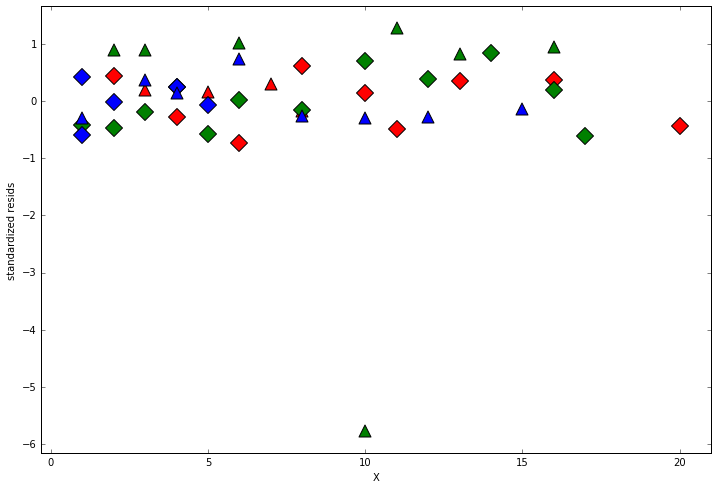

In [22]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, xlabel='X', ylabel='standardized resids')

for values, group in factor_groups:
    i,j = values
    idx = group.index
    ax.scatter(X[idx], resid[idx], marker=symbols[j], color=colors[i-1],
            s=144, edgecolors='black')
ax.axis('tight');

There looks to be an outlier.

#### Find and Remove the Outlier

In [23]:
outl = interM_lm.outlier_test('fdr_bh')
outl.sort('unadj_p', inplace=True)
print(outl)

    student_resid       unadj_p     fdr_bh(p)
32     -14.950832  1.676948e-17  7.713960e-16
33       1.288001  2.055339e-01  9.599254e-01
23       1.023194  3.126860e-01  9.599254e-01
41       0.942329  3.519767e-01  9.599254e-01
11       0.896574  3.755915e-01  9.599254e-01
5        0.890643  3.787254e-01  9.599254e-01
39       0.835081  4.088920e-01  9.599254e-01
38       0.819164  4.178011e-01  9.599254e-01
21       0.729762  4.700104e-01  9.599254e-01
20      -0.726132  4.722071e-01  9.599254e-01
30       0.704477  4.854309e-01  9.599254e-01
28       0.603122  5.500109e-01  9.599254e-01
44      -0.599720  5.522526e-01  9.599254e-01
1       -0.590487  5.583601e-01  9.599254e-01
17      -0.564832  5.755078e-01  9.599254e-01
0       -0.482474  6.322368e-01  9.599254e-01
34      -0.474793  6.376517e-01  9.599254e-01
6       -0.464031  6.452728e-01  9.599254e-01
7        0.428795  6.704934e-01  9.599254e-01
45      -0.426443  6.721915e-01  9.599254e-01
4        0.424446  6.736338e-01  9

In [24]:
idx = salary_table.index.drop(32)

In [25]:
print(idx)

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34,
            35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45],
           dtype='int64')


##### Rerun the original linear model without the outlier

In [26]:
lm32 = ols('S ~ C(E) + X + C(M)', data=salary_table, subset=idx).fit()
print(lm32.summary())

                            OLS Regression Results                            
Dep. Variable:                      S   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     211.7
Date:                Mon, 25 Jan 2016   Prob (F-statistic):           2.45e-26
Time:                        17:10:46   Log-Likelihood:                -373.79
No. Observations:                  45   AIC:                             757.6
Df Residuals:                      40   BIC:                             766.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   8044.7518    392.781     20.482      0.0

#### Interaction Education*Experience

In [27]:
interX_lm32 = ols('S ~ C(E) * X + C(M)', data=salary_table, subset=idx).fit()
print(interX_lm32.summary())

                            OLS Regression Results                            
Dep. Variable:                      S   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     147.7
Date:                Mon, 25 Jan 2016   Prob (F-statistic):           8.97e-25
Time:                        17:10:46   Log-Likelihood:                -371.70
No. Observations:                  45   AIC:                             757.4
Df Residuals:                      38   BIC:                             770.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept    7266.0887    558.872     13.001      

In [28]:
table3 = anova_lm(lm32, interX_lm32)
print(table3)

   df_resid              ssr  df_diff         ss_diff         F    Pr(>F)
0        40  43209096.482552        0             NaN       NaN       NaN
1        38  39374237.269069        2  3834859.213482  1.850508  0.171042


Again, this is not significant, and can be left away.

### Final Result

Result from the Interaction Test: the significant model with Interaction Experience*Management, without the outlier #32

In [29]:
interM_lm32 = ols('S ~ X + C(E) * C(M)', data=salary_table, subset=idx).fit()
print(anova_lm(lm32, interM_lm32))

   df_resid              ssr  df_diff          ss_diff            F  \
0        40  43209096.482552        0              NaN          NaN   
1        38    171188.119937        2  43037908.362615  4776.734853   

         Pr(>F)  
0           NaN  
1  2.291239e-46  


Re-plotting the residuals

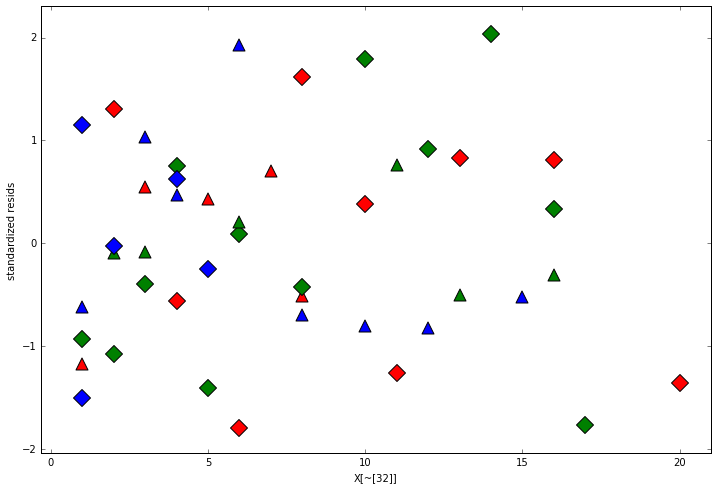

In [30]:
resid = interM_lm32.get_influence().summary_frame()['standard_resid']
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, xlabel='X[~[32]]', ylabel='standardized resids')

for values, group in factor_groups:
    i,j = values
    idx = group.index
    ax.scatter(X[idx], resid[idx], marker=symbols[j], color=colors[i-1],
            s=144, edgecolors='black')
ax.axis('tight');

A final plot of the fitted values

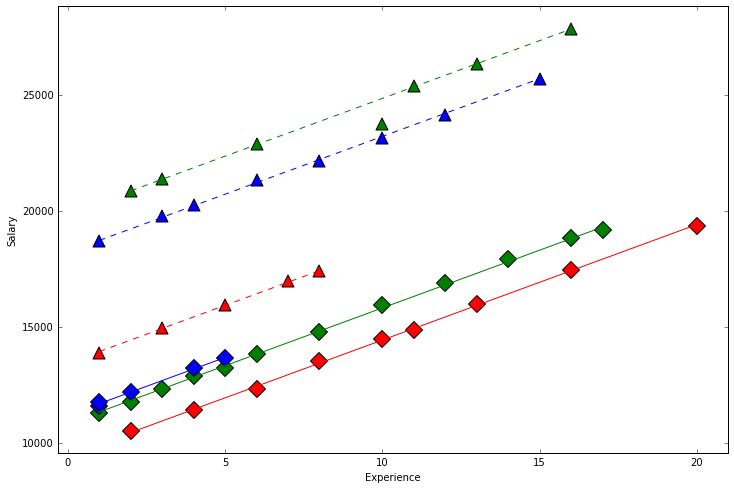

In [31]:
lm_final = ols('S ~ X + C(E)*C(M)', data=salary_table.drop([32])).fit()
mf = lm_final.model.data.orig_exog
lstyle = ['-','--']

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, xlabel='Experience', ylabel='Salary')

for values, group in factor_groups:
    i,j = values
    idx = group.index
    ax.scatter(X[idx], S[idx], marker=symbols[j], color=colors[i-1],
            s=144, edgecolors='black')
    # drop NA because there is no idx 32 in the final model
    ax.plot(mf.X[idx].dropna(), lm_final.fittedvalues[idx].dropna(),
            ls=lstyle[j], color=colors[i-1])
ax.axis('tight');

##### Interaction Plot Salary | Experience

From our first look at the data, the difference between Master's and PhD in the management group is different than in the non-management group. This is an interaction between the two qualitative variables management, M and education, E. We can visualize this by first removing the effect of experience, then plotting the means within each of the 6 groups using interaction.plot.

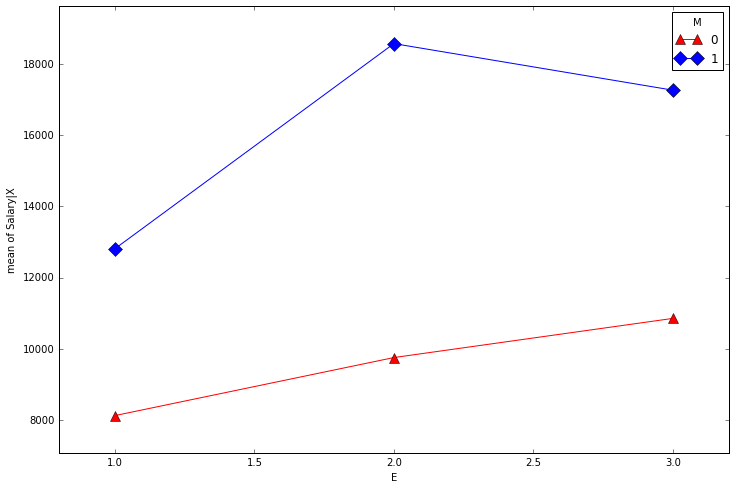

In [32]:
U = S - X * interX_lm32.params['X']
U.name = 'Salary|X'

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax = interaction_plot(E, M, U, colors=['red','blue'], markers=['^','D'],
        markersize=10, ax=ax)

## Example 2: Minority Employment Data - ABLine plotting

In [33]:
from urllib.request import urlopen
url_base = 'https://raw.githubusercontent.com/thomas-haslwanter/statsintro_python/master/ipynb/Data/data_others/'
inFile = 'minority.table'
url = url_base + inFile
minority_table = pandas.read_table(urlopen(url))

#minority_table = pandas.read_table(r'.\Data\data_others\minority.table')
minority_table.to_csv('minority.table', sep="\t", index=False)

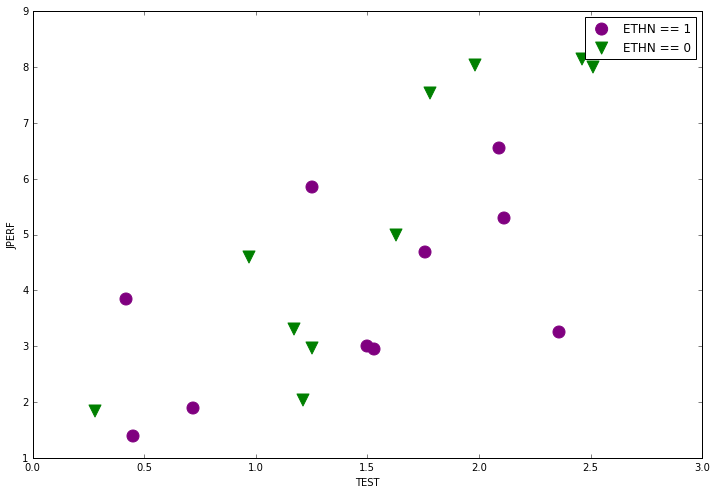

In [34]:
factor_group = minority_table.groupby(['ETHN'])

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, xlabel='TEST', ylabel='JPERF')
colors = ['purple', 'green']
markers = ['o', 'v']
for factor, group in factor_group:
    ax.scatter(group['TEST'], group['JPERF'], color=colors[factor],
                marker=markers[factor], s=12**2)
ax.legend(['ETHN == 1', 'ETHN == 0'], scatterpoints=1)

In [35]:
min_lm = ols('JPERF ~ TEST', data=minority_table).fit()
print(min_lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  JPERF   R-squared:                       0.517
Model:                            OLS   Adj. R-squared:                  0.490
Method:                 Least Squares   F-statistic:                     19.25
Date:                Mon, 25 Jan 2016   Prob (F-statistic):           0.000356
Time:                        17:10:47   Log-Likelihood:                -36.614
No. Observations:                  20   AIC:                             77.23
Df Residuals:                      18   BIC:                             79.22
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      1.0350      0.868      1.192      0.2

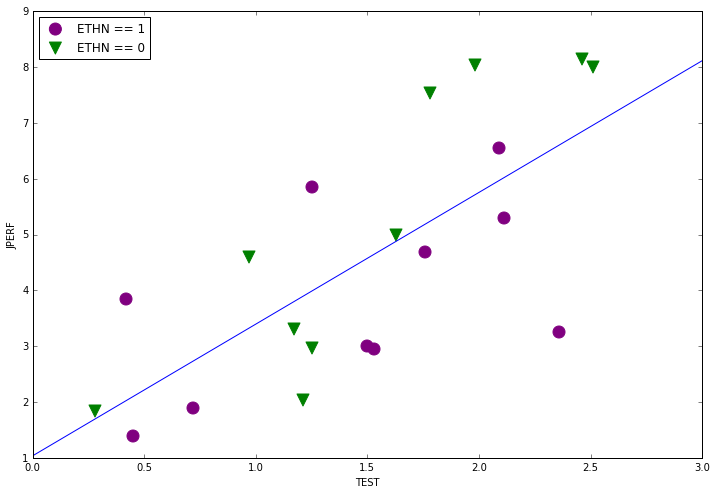

In [36]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, xlabel='TEST', ylabel='JPERF')
for factor, group in factor_group:
    ax.scatter(group['TEST'], group['JPERF'], color=colors[factor],
                marker=markers[factor], s=12**2)
ax.legend(['ETHN == 1', 'ETHN == 0'], scatterpoints=1, loc='upper left')
fig = abline_plot(model_results = min_lm, ax=ax)

In [37]:
min_lm2 = ols('JPERF ~ TEST + TEST:ETHN', data=minority_table).fit()
print(min_lm2.summary())

                            OLS Regression Results                            
Dep. Variable:                  JPERF   R-squared:                       0.632
Model:                            OLS   Adj. R-squared:                  0.589
Method:                 Least Squares   F-statistic:                     14.59
Date:                Mon, 25 Jan 2016   Prob (F-statistic):           0.000204
Time:                        17:10:48   Log-Likelihood:                -33.891
No. Observations:                  20   AIC:                             73.78
Df Residuals:                      17   BIC:                             76.77
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      1.1211      0.780      1.437      0.1

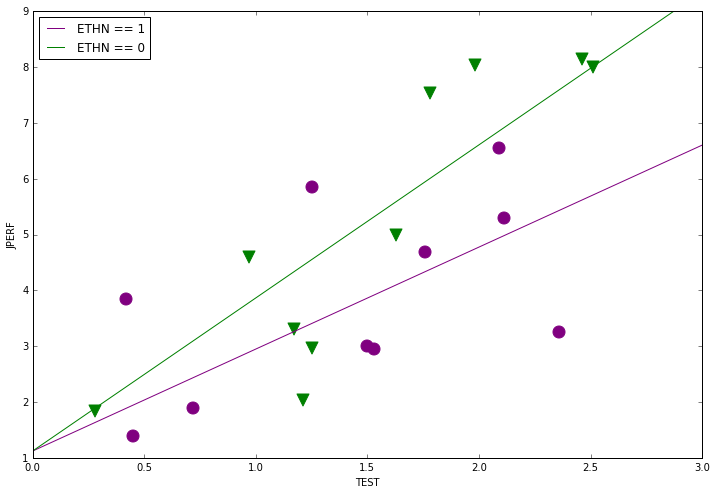

In [38]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, xlabel='TEST', ylabel='JPERF')
for factor, group in factor_group:
    ax.scatter(group['TEST'], group['JPERF'], color=colors[factor],
                marker=markers[factor], s=12**2)

fig = abline_plot(intercept = min_lm2.params['Intercept'],
                 slope = min_lm2.params['TEST'], ax=ax, color='purple')
ax = fig.axes[0]
fig = abline_plot(intercept = min_lm2.params['Intercept'],
        slope = min_lm2.params['TEST'] + min_lm2.params['TEST:ETHN'],
        ax=ax, color='green')
ax.legend(['ETHN == 1', 'ETHN == 0'], scatterpoints=1, loc='upper left');

In [39]:
min_lm3 = ols('JPERF ~ TEST + ETHN', data=minority_table).fit()
print(min_lm3.summary())

                            OLS Regression Results                            
Dep. Variable:                  JPERF   R-squared:                       0.572
Model:                            OLS   Adj. R-squared:                  0.522
Method:                 Least Squares   F-statistic:                     11.38
Date:                Mon, 25 Jan 2016   Prob (F-statistic):           0.000731
Time:                        17:10:48   Log-Likelihood:                -35.390
No. Observations:                  20   AIC:                             76.78
Df Residuals:                      17   BIC:                             79.77
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.6120      0.887      0.690      0.5

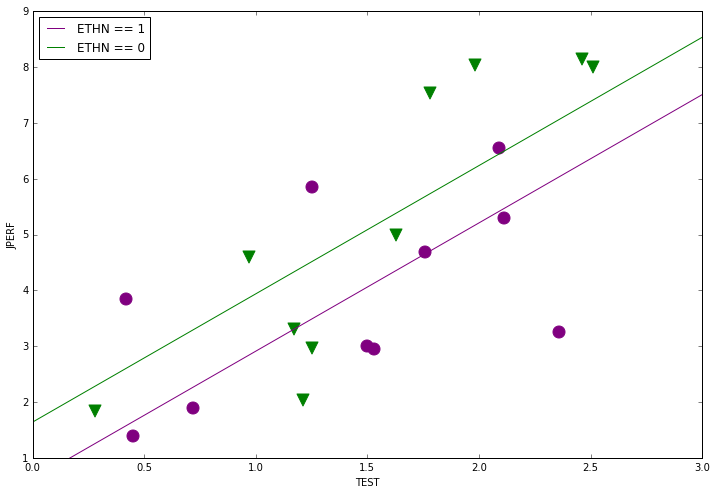

In [40]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, xlabel='TEST', ylabel='JPERF')
for factor, group in factor_group:
    ax.scatter(group['TEST'], group['JPERF'], color=colors[factor],
                marker=markers[factor], s=12**2)

fig = abline_plot(intercept = min_lm3.params['Intercept'],
                 slope = min_lm3.params['TEST'], ax=ax, color='purple')

ax = fig.axes[0]
fig = abline_plot(intercept = min_lm3.params['Intercept'] + min_lm3.params['ETHN'],
        slope = min_lm3.params['TEST'], ax=ax, color='green')
ax.legend(['ETHN == 1', 'ETHN == 0'], scatterpoints=1, loc='upper left');

In [41]:
min_lm4 = ols('JPERF ~ TEST * ETHN', data=minority_table).fit()
print(min_lm4.summary())

                            OLS Regression Results                            
Dep. Variable:                  JPERF   R-squared:                       0.664
Model:                            OLS   Adj. R-squared:                  0.601
Method:                 Least Squares   F-statistic:                     10.55
Date:                Mon, 25 Jan 2016   Prob (F-statistic):           0.000451
Time:                        17:10:48   Log-Likelihood:                -32.971
No. Observations:                  20   AIC:                             73.94
Df Residuals:                      16   BIC:                             77.92
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      2.0103      1.050      1.914      0.0

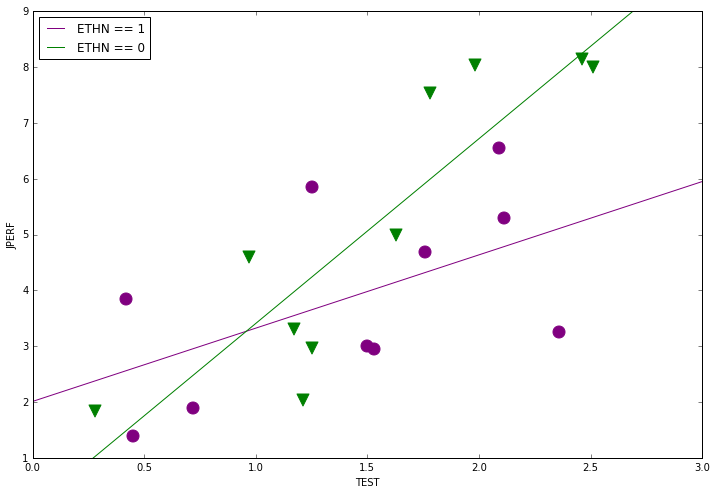

In [42]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, ylabel='JPERF', xlabel='TEST')
for factor, group in factor_group:
    ax.scatter(group['TEST'], group['JPERF'], color=colors[factor],
                marker=markers[factor], s=12**2)

fig = abline_plot(intercept = min_lm4.params['Intercept'],
                 slope = min_lm4.params['TEST'], ax=ax, color='purple')
ax = fig.axes[0]
fig = abline_plot(intercept = min_lm4.params['Intercept'] + min_lm4.params['ETHN'],
        slope = min_lm4.params['TEST'] + min_lm4.params['TEST:ETHN'],
        ax=ax, color='green')
ax.legend(['ETHN == 1', 'ETHN == 0'], scatterpoints=1, loc='upper left');

Is there any effect of ETHN on slope or intercept?
<br />
Y ~ TEST vs. Y ~ TEST + ETHN + ETHN:TEST

In [43]:
table5 = anova_lm(min_lm, min_lm4)
print(table5)

   df_resid        ssr  df_diff    ss_diff         F    Pr(>F)
0        18  45.568297        0        NaN       NaN       NaN
1        16  31.655473        2  13.912824  3.516061  0.054236


Is there any effect of ETHN on intercept?
<br />
Y ~ TEST vs. Y ~ TEST + ETHN

In [44]:
table6 = anova_lm(min_lm, min_lm3)
print(table6)

   df_resid        ssr  df_diff   ss_diff         F    Pr(>F)
0        18  45.568297        0       NaN       NaN       NaN
1        17  40.321546        1  5.246751  2.212087  0.155246


Is there any effect of ETHN on slope?
<br />
Y ~ TEST vs. Y ~ TEST + ETHN:TEST

In [45]:
table7 = anova_lm(min_lm, min_lm2)
print(table7)

   df_resid        ssr  df_diff    ss_diff         F    Pr(>F)
0        18  45.568297        0        NaN       NaN       NaN
1        17  34.707653        1  10.860644  5.319603  0.033949


Is it just the slope or both?
<br />
Y ~ TEST + ETHN:TEST vs Y ~ TEST + ETHN + ETHN:TEST

In [46]:
table8 = anova_lm(min_lm2, min_lm4)
print(table8)

   df_resid        ssr  df_diff  ss_diff         F    Pr(>F)
0        17  34.707653        0      NaN       NaN       NaN
1        16  31.655473        1  3.05218  1.542699  0.232115


### Two Way ANOVA - Kidney failure data

In [47]:
try:
    kidney_table = pandas.read_table('kidney.table')
except:
    url = 'http://stats191.stanford.edu/data/kidney.table'
    kidney_table = pandas.read_table(url, delimiter=" *")
    kidney_table.to_csv("kidney.table", sep="\t", index=False)

In [48]:
# Explore the dataset, it's a balanced design
print(kidney_table.groupby(['Weight', 'Duration']).size())

Weight  Duration
1       1           10
        2           10
2       1           10
        2           10
3       1           10
        2           10
dtype: int64


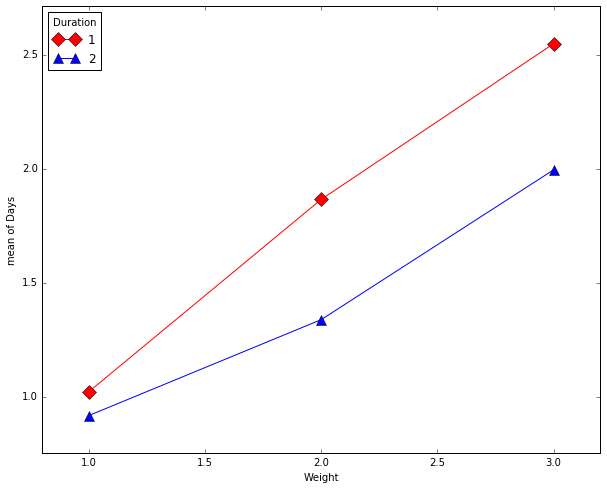

In [49]:
kt = kidney_table
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
fig = interaction_plot(kt['Weight'], kt['Duration'], np.log(kt['Days']+1),
        colors=['red', 'blue'], markers=['D','^'], ms=10, ax=ax)

$$Y_{ijk} = \mu + \alpha_i + \beta_j + \left(\alpha\beta\right)_{ij}+\epsilon_{ijk}$$

with 

$$\epsilon_{ijk}\sim N\left(0,\sigma^2\right)$$

In [50]:
help(anova_lm)

Help on function anova_lm in module statsmodels.stats.anova:

anova_lm(*args, **kwargs)
    ANOVA table for one or more fitted linear models.
    
    Parameters
    ----------
    args : fitted linear model results instance
        One or more fitted linear models
    scale : float
        Estimate of variance, If None, will be estimated from the largest
        model. Default is None.
    test : str {"F", "Chisq", "Cp"} or None
        Test statistics to provide. Default is "F".
    typ : str or int {"I","II","III"} or {1,2,3}
        The type of ANOVA test to perform. See notes.
    robust : {None, "hc0", "hc1", "hc2", "hc3"}
        Use heteroscedasticity-corrected coefficient covariance matrix.
        If robust covariance is desired, it is recommended to use `hc3`.
    
    Returns
    -------
    anova : DataFrame
    A DataFrame containing.
    
    Notes
    -----
    Model statistics are given in the order of args. Models must have
    been fit using the formula api.
    
   

Things available in the calling namespace are available in the formula evaluation namespace

In [51]:
kidney_lm = ols('np.log(Days+1) ~ C(Duration) * C(Weight)', data=kt).fit()

ANOVA Type-I Sum of Squares
<br /><br />
SS(A) for factor A. <br />
SS(B|A) for factor B. <br />
SS(AB|B, A) for interaction AB. <br />

In [52]:
print(anova_lm(kidney_lm))

                       df     sum_sq   mean_sq          F    PR(>F)
C(Duration)             1   2.339693  2.339693   4.358293  0.041562
C(Weight)               2  16.971291  8.485645  15.806745  0.000004
C(Duration):C(Weight)   2   0.635658  0.317829   0.592040  0.556748
Residual               54  28.989198  0.536837        NaN       NaN


ANOVA Type-II Sum of Squares
<br /><br />
SS(A|B) for factor A. <br />
SS(B|A) for factor B. <br />

In [53]:
print(anova_lm(kidney_lm, typ=2))

                          sum_sq  df          F    PR(>F)
C(Duration)             2.339693   1   4.358293  0.041562
C(Weight)              16.971291   2  15.806745  0.000004
C(Duration):C(Weight)   0.635658   2   0.592040  0.556748
Residual               28.989198  54        NaN       NaN


In [54]:
print(anova_lm(ols('np.log(Days+1) ~ C(Duration, Sum) * C(Weight, Poly)', 
                   data=kt).fit(), typ=3))

                                      sum_sq  df           F        PR(>F)
Intercept                         156.301830   1  291.153237  2.077589e-23
C(Duration, Sum)                    2.339693   1    4.358293  4.156170e-02
C(Weight, Poly)                    16.971291   2   15.806745  3.944502e-06
C(Duration, Sum):C(Weight, Poly)    0.635658   2    0.592040  5.567479e-01
Residual                           28.989198  54         NaN           NaN


#### Excercise: Find the 'best' model for the kidney failure dataset